<h1 style="color: navy; text-align: center;">Credit Risk Model Exploratory Data Analysis</h1>
<p style="text-align: justify; font-size: 16px;">
This notebook delves into the dataset's data exploration, providing insights crucial for evaluating the default risk of potential clients. By enabling consumer finance providers to approve a higher number of loan applications, this analysis contributes to improving the financial inclusiveness of individuals previously excluded due to insufficient credit history.
</p>


In [103]:
import sys
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_style("white")
sns.set_palette("colorblind") 
sns.set_context("talk")

from helpers import *

<h1 style="color: navy; font-family: Verdana, Geneva, sans-serif;">Exploring Information for Depth 0</h1>

<p style="font-size: 16px; font-family: 'Lucida Grande', 'Lucida Sans Unicode', Arial, sans-serif; color: #333;">
  At depth zero, we have <strong style="color: darkred;">static features</strong> tied to a specific credit case. All the features here can be directly used as predictors.
</p>


In [11]:
# Getting column defintions
col_defs = {row['Variable']: row['Description'] for row in pl.read_csv("feature_definitions.csv").to_dicts()}

# Merging information
final_df = pl.concat([change_column_type(pl.read_csv("csv_files/train/train_static_0_0.csv")), 
                      change_column_type(pl.read_csv("csv_files/train/train_static_0_1.csv"))], how="vertical_relaxed").join(change_column_type(pl.read_csv("csv_files/train/train_static_cb_0.csv")), on="case_id", how="left")
print(f"------> Size of dataset without targets {final_df.shape} <------") 

# extract descriptive information for each column
descriptive_col = {col : col_defs[col] for col in final_df.columns[1:]}

final_df = final_df.join(change_column_type(pl.read_csv("csv_files/train/train_base.csv")), on="case_id", how="inner")
print(f"------> Size of dataset with targets {final_df.shape} <------") 

# adding target columns to descriptive_col
descriptive_col['date_decision']= "This refers to the date when a decision was made regarding the approval of the loan."
descriptive_col['MONTH']= "Month the decision was made"
descriptive_col['WEEK_NUM']= "This is the week number used for aggregation. In the test sample, WEEK_NUM continues sequentially from the last training value of WEEK_NUM"
descriptive_col['target']= " This is the target value, determined after a certain period based on whether or not the client defaulted on the specific credit case (loan)"


------> Size of dataset without targets (1526659, 220) <------
------> Size of dataset with targets (1526659, 224) <------


<div style="text-align: center;">
    <img src="images/confused.gif" 00" alt="Confused">
    <p style="text-align: center; font-style: italic; font-weight: bold;">Just the 224 Columns Then.........</p>
</div>

## Checking for duplicate columns and rows

In [12]:
# Duplicate column check
non_unique_cols_descriptions = find_duplicate_values(descriptive_col)
similar = verify_exact_duplicates_from_pairs(final_df, non_unique_cols_descriptions)
print(f"We have {len(similar)} duplicate columns")

# Duplicate rows check
dup_mask = (final_df.is_duplicated()).sum()
print(f"We have {dup_mask} duplicated rows")

# convert to pandas
# final_df = final_df.to_pandas() 

We have 0 duplicate columns
We have 0 duplicated rows


## Dataset Challenges

### Overview of null values in the dataset

In [21]:
# calculate null percentage for each column
null_percentages = []
for col in final_df.columns:
    null_percentage = final_df[col].is_null().mean()*100
    null_percentages.append(null_percentage)

# create a dataframe
null_percentages = pl.DataFrame({"Columns":final_df.columns, "Null Percentage": null_percentages})

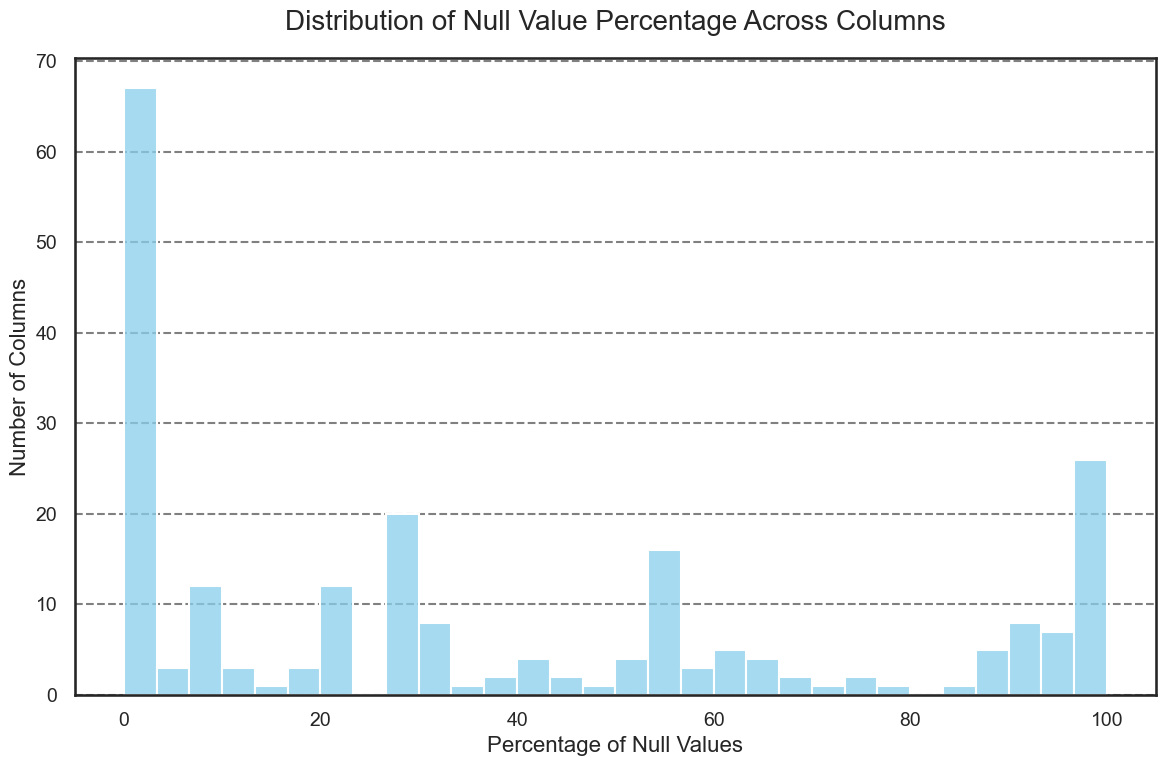

In [27]:
# Set up the matplotlib figure, and adjust the size for clarity
plt.figure(figsize=(12, 8))

# Create the histogram
sns.histplot(data=null_percentages, x='Null Percentage', bins=30, kde=False, color='skyblue')

# Customizations for accessibility: clear labels, title, and larger text sizes
plt.title('Distribution of Null Value Percentage Across Columns', fontsize=20, pad=20)
plt.xlabel('Percentage of Null Values', fontsize=16)
plt.ylabel('Number of Columns', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', color='gray')  # Add grid lines for easier reading

# Show the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()   

### Preliminary Null Percentage Breakdown

In [26]:
len_no_nulls = null_percentages.filter(pl.col('Null Percentage') == 0).height
len_10_nulls = null_percentages.filter(pl.col('Null Percentage') <= 10).height

# Percentage calculations
total_columns = final_df.shape[1]  # Total number of columns for reference
no_nulls_percentage = (len_no_nulls / total_columns) * 100
ten_nulls_percentage = (len_10_nulls / total_columns) * 100

# Formatted output
formatted_text = (f"Columns with 0% null values represent {no_nulls_percentage:.2f}% "
                  f"of the total columns ({len_no_nulls} columns).\n"
                  f"Columns with up to 10% null values represent {ten_nulls_percentage:.2f}% "
                  f"of the total columns ({len_10_nulls} columns).")
print(formatted_text)

Columns with 0% null values represent 22.77% of the total columns (51 columns).
Columns with up to 10% null values represent 36.61% of the total columns (82 columns).


### Class Imbalance

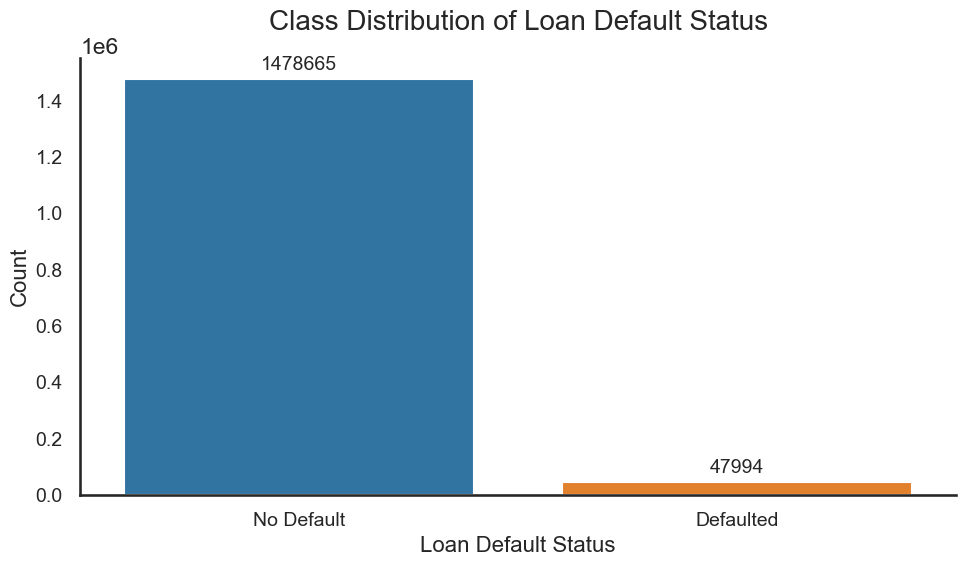

In [46]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
target_counts = (final_df.select(pl.col('target')).group_by('target').len().sort('target')).to_pandas()   
ax = sns.barplot(x='target', y='len', data=target_counts, palette=['#1f77b4', '#ff7f0e'])

# Add titles and labels for clarity
plt.title('Class Distribution of Loan Default Status', fontsize=20, pad=20)
plt.xlabel('Loan Default Status', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['No Default', 'Defaulted'], fontsize=14)  # Custom labels for clarity
plt.yticks(fontsize=14)

# Add annotations to each bar for better clarity
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=14)

# Remove gridlines and spines for a cleaner look
sns.despine()

# Show plot
plt.tight_layout()  # Adjust layout to make room for the plot labels
plt.show()

<p>Our analysis reveals a significant insight: <strong>a predominant portion of the dataset exhibits more than 10% missing values</strong>, indicating a notable imbalance in the data. This condition presents unique challenges for our project objectives. Specifically, the presence of numerous missing values, or 'sparsity', complicates straightforward data treatment strategies such as substituting missing values with statistical measures (mean, mode, etc.). Such substitutions risk distorting the prediction outcomes, potentially leading to inaccuracies in identifying defaulting and non-defaulting loans.</p>

<p>To navigate these challenges effectively, we approach missing values as distinct features themselves, rather than simply gaps to fill. Our strategic goals include:</p>

- **Enhancing Prediction Scorecards:** In the dynamic landscape of client behavior, maintaining up-to-date and reliable prediction scorecards is paramount. Regular updates are essential for accuracy, yet time-consuming. The future stability of these scorecards is crucial; any sudden decline in their predictive performance could result in the approval of loans for higher-risk clients. Early detection of potential issues becomes challenging when significant indicators emerge only after the observation of initial loan repayments. The balance between a scorecard’s stability and its predictive accuracy is vital, necessitating a careful calibration before deployment.
- **Advancing Data Interpretability:** We aim to redefine sparse data by transforming row descriptions into structured, tokenized formats that are computationally friendly. This process involves introducing semantic definitions to the dataset, enabling the conversion of loosely structured information into tokenized embeddings. These embeddings will later facilitate more sophisticated data processing and analysis techniques, enhancing our model's ability to understand and predict based on nuanced data characteristics.

<p>Through these initiatives, we strive to refine our predictive models, balancing precision and stability to meet the evolving demands of the loan provision sector.</p>


# Preliminary Exploratory Analysis

## Credit Type Analysis

### Most Popular credit type

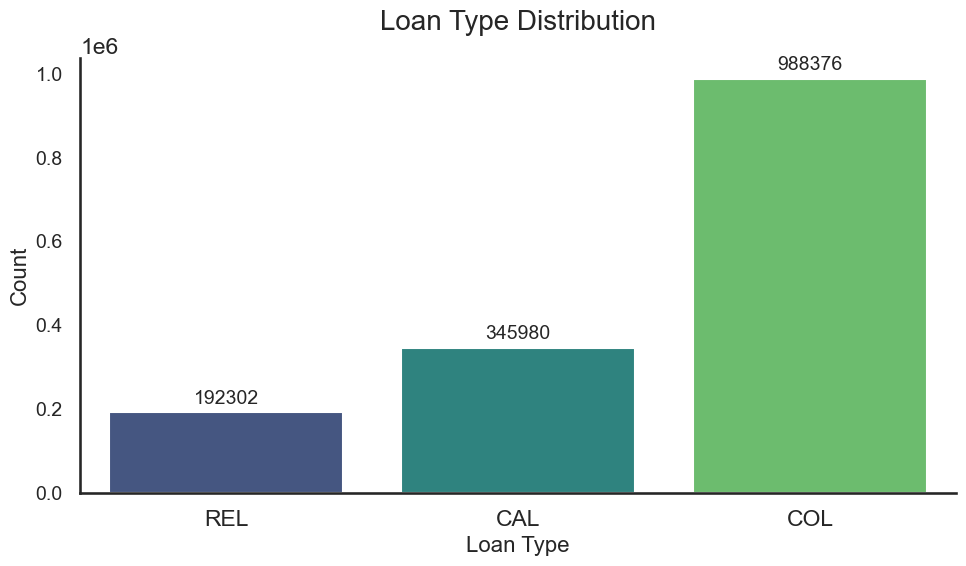

In [82]:
# credit-type count
credit_type = (final_df.group_by('credtype_322L').agg(pl.len()).sort('len')).to_pandas()   

plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
ax = sns.barplot(x='credtype_322L', y='len', data=credit_type, palette="viridis")

# Add titles and labels for clarity
plt.title('Loan Type Distribution', fontsize=20, pad=20)
plt.xlabel('Loan Type', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.yticks(fontsize=14)

# Add annotations to each bar for better clarity
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=14)

# Remove gridlines and spines for a cleaner look
sns.despine()

# Show plot
plt.tight_layout()  # Adjust layout to make room for the plot labels
plt.show()

### Default rates for each credit type

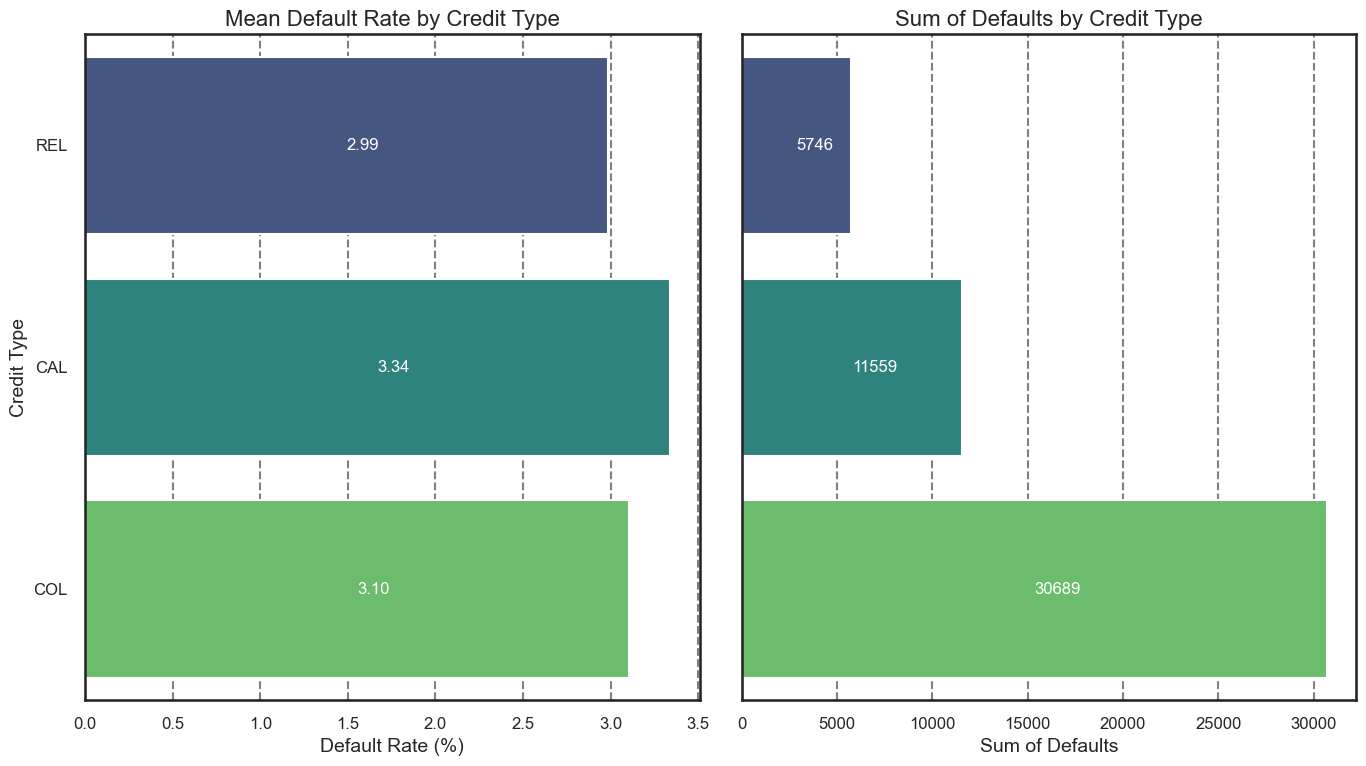

In [83]:
default_rate = final_df.group_by('credtype_322L').agg([(pl.col('target').mean()*100).alias("Default Rate (%)"), (pl.col('target').sum()).alias('Total Defaults')]).to_pandas()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 8), dpi=100, sharey=True)  # 1 Row, 2 Columns, shared y-axis

# Horizontal bar plot for Default Rate (%)
sns.barplot(y="credtype_322L", x="Default Rate (%)", data=default_rate, ax=axes[0], palette="viridis")
axes[0].set_title('Mean Default Rate by Credit Type', fontsize=16)
axes[0].set_ylabel('Credit Type', fontsize=14)
axes[0].set_xlabel('Default Rate (%)', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='x', linestyle='--', color='gray')

# Add annotations to the default rate plot
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.2f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

# Horizontal bar plot for Total Defaults
sns.barplot(y="credtype_322L", x="Total Defaults", data=default_rate, ax=axes[1], palette="viridis")
axes[1].set_title('Sum of Defaults by Credit Type', fontsize=16)
axes[1].set_xlabel('Sum of Defaults', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='x', linestyle='--', color='gray')
axes[1].set_ylabel('', fontsize=14)  # Not needed due to sharey=True

# Add annotations to the total defaults plot
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.0f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

plt.tight_layout()
plt.show()

### Weekly default rate performance

In [84]:
default_rate = final_df.group_by('WEEK_NUM').agg([(pl.col('target').mean()*100).alias("Default Rate (%)"), (pl.col('target').sum()).alias('Total Defaults')]).to_pandas()

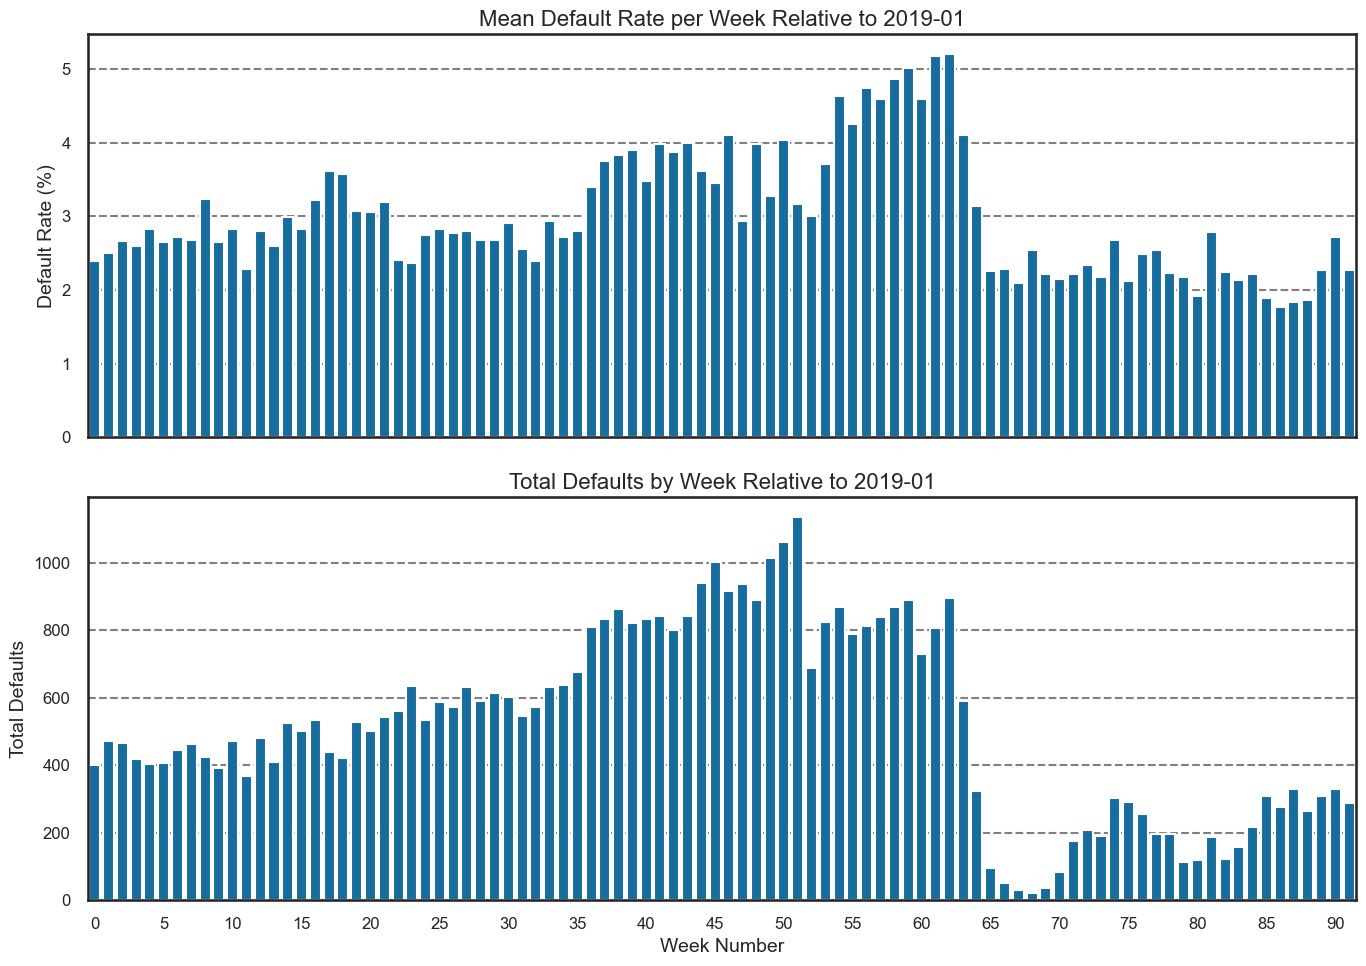

In [104]:
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100, sharex=True)  # 1 Row, 2 Columns, shared x-axis

# vertical bar plot for Default Rate (%)
sns.barplot(y="Default Rate (%)", x="WEEK_NUM", data=default_rate, ax=axes[0], color="#0072B2")
axes[0].set_title('Mean Default Rate per Week Relative to 2019-01', fontsize=16)
axes[0].set_ylabel('Default Rate (%)', fontsize=14)
axes[0].set_xlabel('', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='y', linestyle='--', color='gray')

sns.barplot(y="Total Defaults", x="WEEK_NUM", data=default_rate, ax=axes[1], color="#0072B2")
axes[1].set_title('Total Defaults by Week Relative to 2019-01', fontsize=16)
axes[1].set_ylabel('Total Defaults', fontsize=14)
axes[1].set_xlabel('Week Number', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='y', linestyle='--', color='gray')
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.tight_layout()
plt.show()

### Predicted risk estimate vs Default Percentage

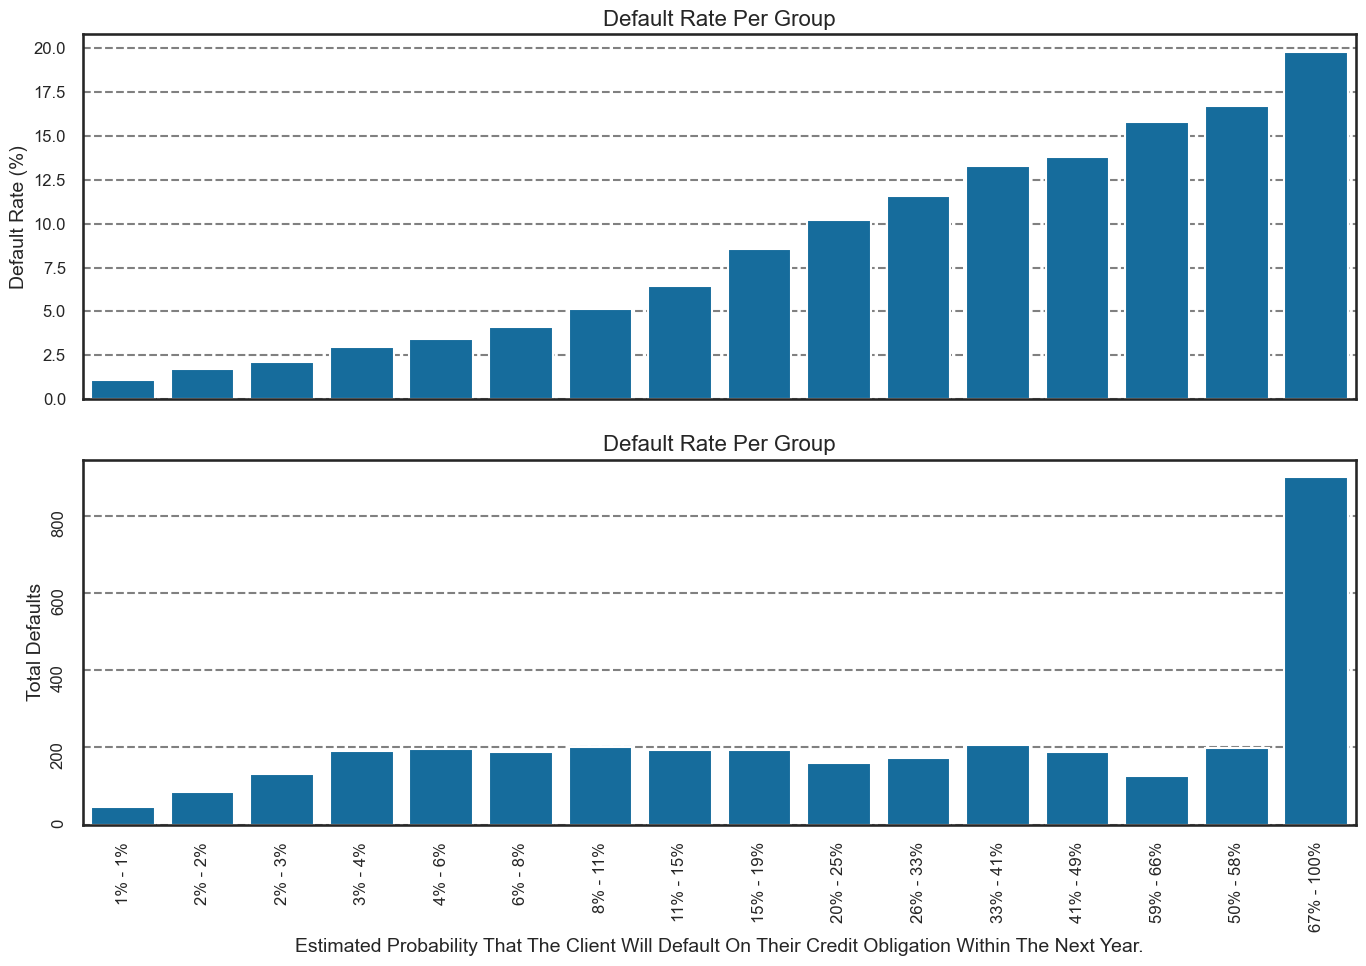

In [125]:
# credit-type count
curr_col='riskassesment_302T'
x_axis_desc = descriptive_col[curr_col].title()
title = 'Default Rate Per Group'
credit_type =final_df.group_by(curr_col).agg([(pl.col('target').mean()*100).alias("Default Rate (%)"), (pl.col('target').sum()).alias('Total Defaults')]).sort('Default Rate (%)').to_pandas()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100, sharex=True)  # 1 Row, 2 Columns, shared x-axis

# vertical bar plot for Default Rate (%)
sns.barplot(y="Default Rate (%)", x=curr_col, data=credit_type, ax=axes[0], color="#0072B2")
axes[0].set_title(title, fontsize=16)
axes[0].set_ylabel('Default Rate (%)', fontsize=14)
axes[0].set_xlabel('', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='y', linestyle='--', color='gray')

sns.barplot(y="Total Defaults", x=curr_col, data=credit_type, ax=axes[1], color="#0072B2")
axes[1].set_title(title, fontsize=16)
axes[1].set_ylabel('Total Defaults', fontsize=14)
axes[1].set_xlabel(x_axis_desc, fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12, labelrotation=90)
axes[1].grid(axis='y', linestyle='--', color='gray')
# axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.tight_layout()
plt.show()

### Focusing on group with predicted 67-100 % default

In [135]:
curr_df = final_df.filter(pl.col('riskassesment_302T')=="67% - 100%")
curr_df.shape

(4549, 224)

#### Most Popular credit type

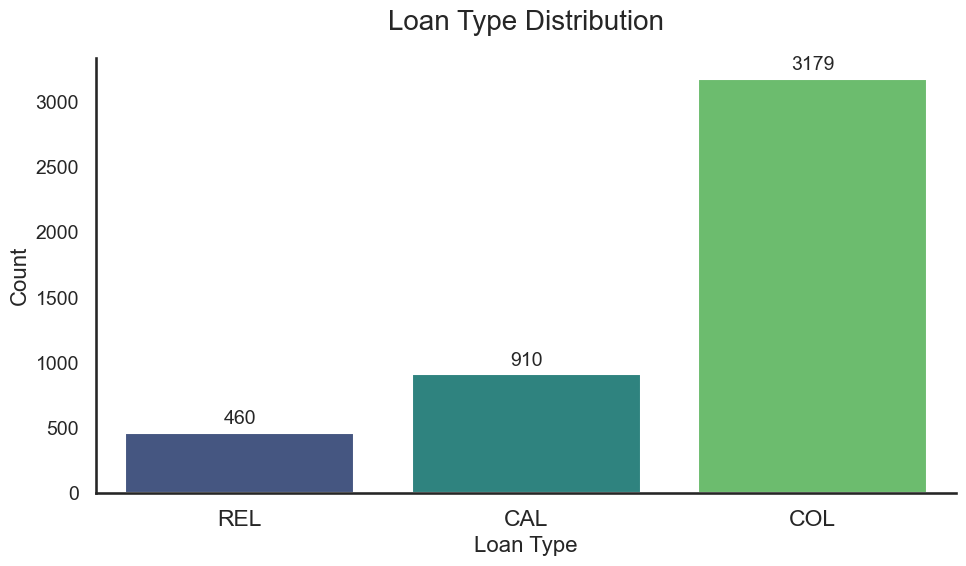

In [136]:
# credit-type count
credit_type = (curr_df.group_by('credtype_322L').agg(pl.len()).sort('len')).to_pandas()   

plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
ax = sns.barplot(x='credtype_322L', y='len', data=credit_type, palette="viridis")

# Add titles and labels for clarity
plt.title('Loan Type Distribution', fontsize=20, pad=20)
plt.xlabel('Loan Type', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.yticks(fontsize=14)

# Add annotations to each bar for better clarity
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=14)

# Remove gridlines and spines for a cleaner look
sns.despine()

# Show plot
plt.tight_layout()  # Adjust layout to make room for the plot labels
plt.show()

#### Default rates for each credit type

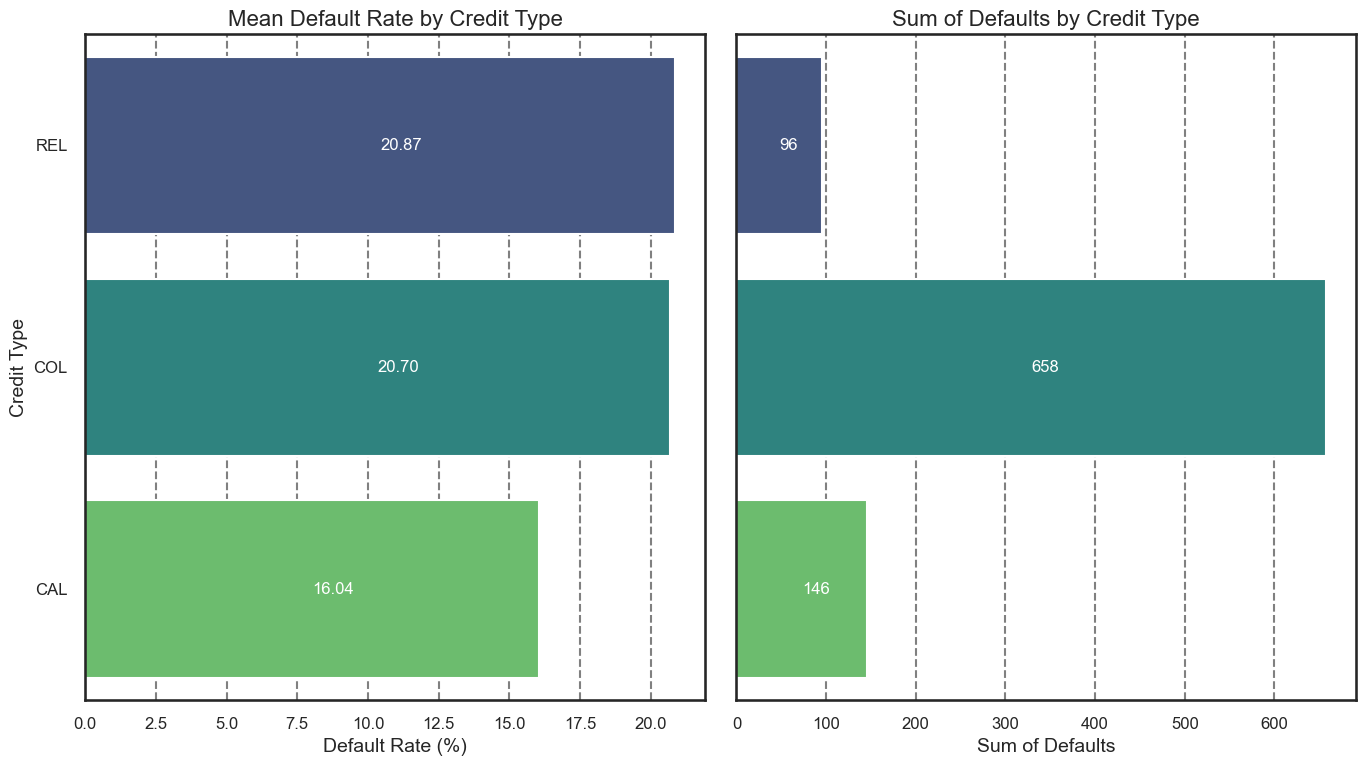

In [137]:
default_rate = curr_df.group_by('credtype_322L').agg([(pl.col('target').mean()*100).alias("Default Rate (%)"), (pl.col('target').sum()).alias('Total Defaults')]).to_pandas()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 8), dpi=100, sharey=True)  # 1 Row, 2 Columns, shared y-axis

# Horizontal bar plot for Default Rate (%)
sns.barplot(y="credtype_322L", x="Default Rate (%)", data=default_rate, ax=axes[0], palette="viridis")
axes[0].set_title('Mean Default Rate by Credit Type', fontsize=16)
axes[0].set_ylabel('Credit Type', fontsize=14)
axes[0].set_xlabel('Default Rate (%)', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='x', linestyle='--', color='gray')

# Add annotations to the default rate plot
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.2f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

# Horizontal bar plot for Total Defaults
sns.barplot(y="credtype_322L", x="Total Defaults", data=default_rate, ax=axes[1], palette="viridis")
axes[1].set_title('Sum of Defaults by Credit Type', fontsize=16)
axes[1].set_xlabel('Sum of Defaults', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='x', linestyle='--', color='gray')
axes[1].set_ylabel('', fontsize=14)  # Not needed due to sharey=True

# Add annotations to the total defaults plot
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.0f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

plt.tight_layout()
plt.show()

#### Education Status

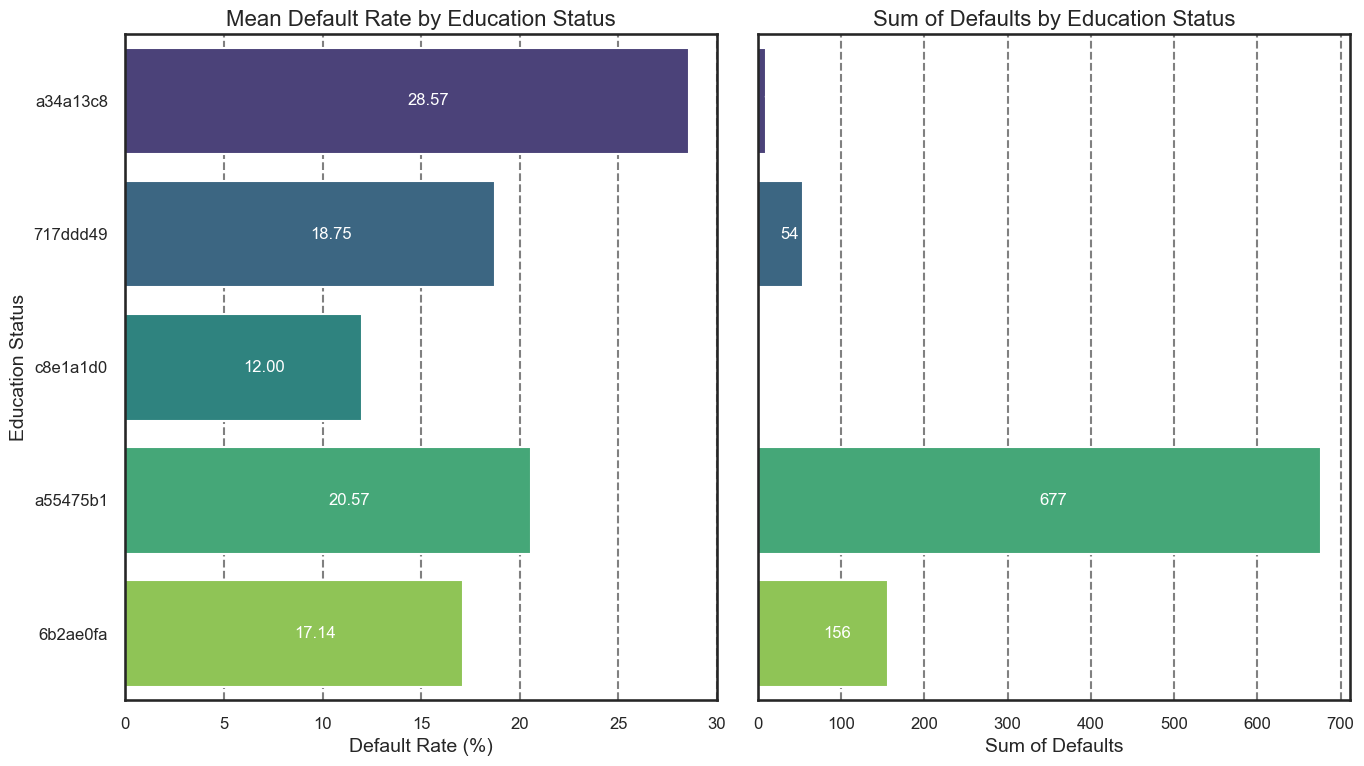

In [139]:
default_rate = curr_df.group_by('education_88M').agg([(pl.col('target').mean()*100).alias("Default Rate (%)"), (pl.col('target').sum()).alias('Total Defaults')]).to_pandas()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 8), dpi=100, sharey=True)  # 1 Row, 2 Columns, shared y-axis

# Horizontal bar plot for Default Rate (%)
sns.barplot(y="education_88M", x="Default Rate (%)", data=default_rate, ax=axes[0], palette="viridis")
axes[0].set_title('Mean Default Rate by Education Status', fontsize=16)
axes[0].set_ylabel('Education Status', fontsize=14)
axes[0].set_xlabel('Default Rate (%)', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='x', linestyle='--', color='gray')

# Add annotations to the default rate plot
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.2f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

# Horizontal bar plot for Total Defaults
sns.barplot(y="education_88M", x="Total Defaults", data=default_rate, ax=axes[1], palette="viridis")
axes[1].set_title('Sum of Defaults by Education Status', fontsize=16)
axes[1].set_xlabel('Sum of Defaults', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='x', linestyle='--', color='gray')
axes[1].set_ylabel('', fontsize=14)  # Not needed due to sharey=True

# Add annotations to the total defaults plot
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.0f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

plt.tight_layout()
plt.show()

#### Marital Status

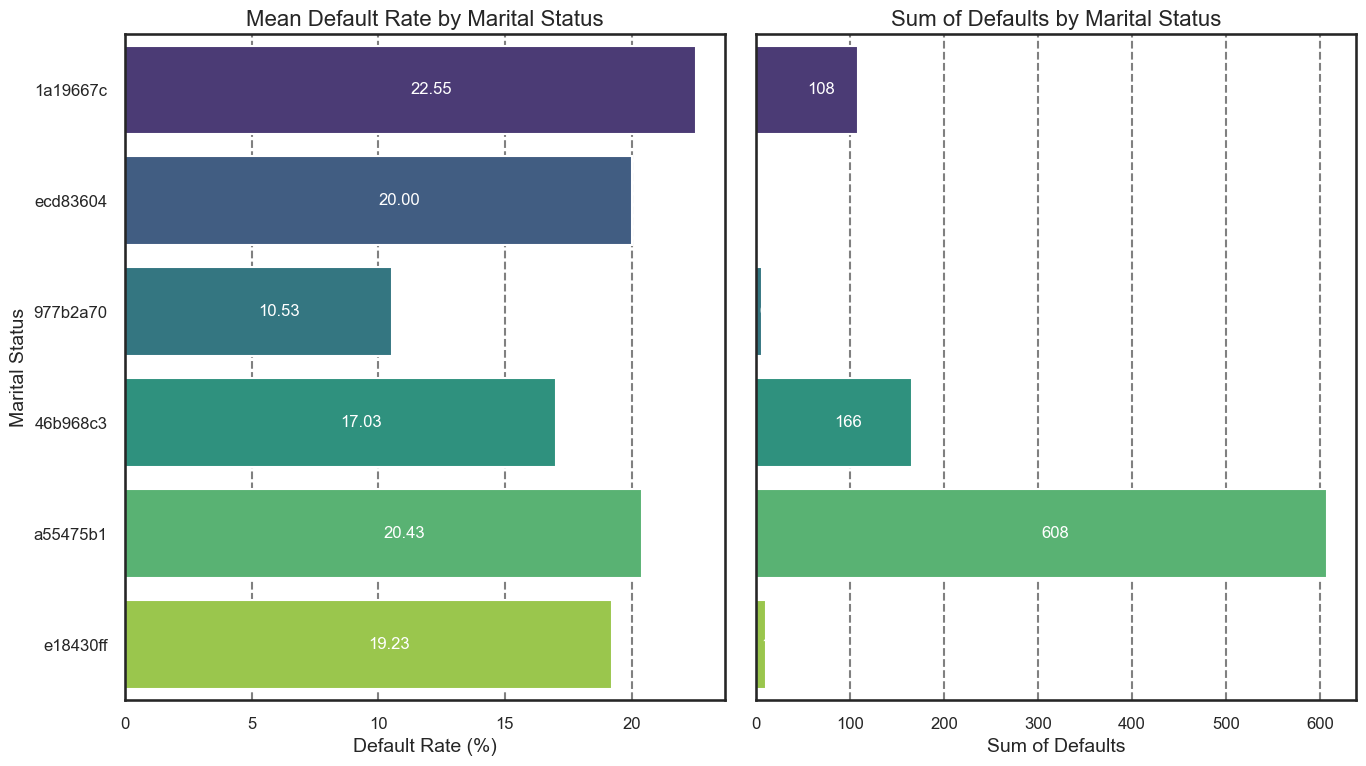

In [142]:
default_rate = curr_df.group_by('maritalst_893M').agg([(pl.col('target').mean()*100).alias("Default Rate (%)"), (pl.col('target').sum()).alias('Total Defaults')]).to_pandas()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 8), dpi=100, sharey=True)  # 1 Row, 2 Columns, shared y-axis

# Horizontal bar plot for Default Rate (%)
sns.barplot(y="maritalst_893M", x="Default Rate (%)", data=default_rate, ax=axes[0], palette="viridis")
axes[0].set_title('Mean Default Rate by Marital Status', fontsize=16)
axes[0].set_ylabel('Marital Status', fontsize=14)
axes[0].set_xlabel('Default Rate (%)', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='x', linestyle='--', color='gray')

# Add annotations to the default rate plot
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.2f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

# Horizontal bar plot for Total Defaults
sns.barplot(y="maritalst_893M", x="Total Defaults", data=default_rate, ax=axes[1], palette="viridis")
axes[1].set_title('Sum of Defaults by Marital Status', fontsize=16)
axes[1].set_xlabel('Sum of Defaults', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='x', linestyle='--', color='gray')
axes[1].set_ylabel('', fontsize=14)  # Not needed due to sharey=True

# Add annotations to the total defaults plot
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(width/2,  # x-position
                 p.get_y() + p.get_height() / 2,  # y-position
                 '{:1.0f}'.format(width),  # value to display
                 ha = 'left',   # center the text
                 va = 'center', 
                 fontsize=12, color='white')

plt.tight_layout()
plt.show()

<h3 style="text-align: center;"><span style="font-weight: bold; color: #2E86C1;">Analysis Highlights:</span></h3>

<p style="text-align: justify;">
    Further analysis uncovered that clients with specific demographic characteristics— those with a marital status and education status both identified by the unique identifier <span style="font-weight: bold; color: #C0392B;">'a55475b1'</span>, and possessing a credit type lalbeled as <span style="font-weight: bold; color: #C0392B;">'Col'</span>— exhibit are the most likely to default their credit loans.
</p>

<p style="text-align: justify;">
    These findings emerged as the most important when considering the impact on the target variable. Further exploratory analysis into the relationship with the <span style="font-weight: bold; color: #C0392B;">WeekNumber</span> has also yielded significant insights. A select snippet, previously illustrated, showcased an instance of observed pattern worth noting. However, to maintain focus and clarity within this exposition, additional plots demonstrating more extensive relations concerning the <span style="font-weight: bold; color: #C0392B;">WeekNumber</span> have been omitted from this notebook.
</p>


# Future Steps:

<h2 style="color: #2E86C1;">The Case for Tokenization</h2>

<p>Due to the significant presence of <span style="font-weight: bold; color: #D35400;">null values</span> in the dataset, combined with the sensitivity of the use case, traditional methods to deal with null values (such as mean, mode, etc.) can inadvertently increase the risk of analytical errors. Specifically, these methods might:</p>

<ul>
    <li><strong>Increase the chances of false positives</strong>, which is detrimental to the user experience.</li>
    <li><strong>Lead to a higher rate of false negatives</strong>, adversely affecting the client's outcomes.</li>
</ul>

<p>Given these concerns, a more nuanced approach is required to maintain the integrity of the data analysis process. <span style="font-style: italic; color: #117A65;">I propose borrowing techniques from the realm of recommender systems</span>, which excel at incorporating semantic context into the data. This approach allows us to:</p>

<ol>
    <li><strong>Enhance Data Quality</strong>: By leveraging semantic understanding, we can impute missing values in a way that respects the inherent patterns and relationships within the data.</li>
    <li><strong>Reduce Analytical Errors</strong>: Minimizing false positives and false negatives becomes more feasible when the data's context and semantics are considered during the imputation process.</li>
    <li><strong>Improve Decision-Making</strong>: With a more reliable dataset, stakeholders can make informed decisions based on insights that accurately reflect the underlying realities.</li>
</ol>

<p>This method underscores the importance of adopting innovative data processing techniques, especially in scenarios where traditional approaches fall short.</p>
